# Reasearch topic：透過ptt鄉民文章，探討台灣躺平族成因
###  躺平族：躺平族意旨放棄遠大生活目標，強調低消費、低物慾和及時行樂
### 動機：
* 躺平族強調低收入低消費，不利國家提升競爭力，降低國家經濟發展
* 近年各國逐漸出現躺平主義，但各國家人民面對的困境不盡相同，因此希望透過文字探勘分析ptt上的討論文章了解台灣躺平族成因
### 目標：
* 分析台灣躺平族成因
* 分析台灣躺平族理念與行為

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
import matplotlib
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 
import math
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import configparser, re, os, io
from wordcloud import WordCloud, ImageColorGenerator
import time
from datetime import datetime, timedelta
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize

In [143]:
import matplotlib as mpl
import matplotlib.pyplot as plt 

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

# 設定字型
FontPath = 'raw_data/SourceHanSansTW-Regular.otf' 

# 1.資料處理

## 1.1資料前處理

In [144]:
#Import the dataset
MetaData = pd.read_csv('raw_data\Lie-Flat.csv')

#將artDate欄位只留下 年/月/日
MetaData['artDate'] = pd.to_datetime(MetaData['artDate']).dt.date

In [145]:
print(f"共有 {MetaData.shape[0]} 篇文章") #(row,column)
MetaData.head(1)

共有 625 篇文章


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,vincentwjs,China_Drama,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""larusa"", ""cm...",42.73.152.172,2022-05-04 01:06:35,ptt


## 1.2 資料清理

* 去除NA值
* 正規化資料清理
* 去除不是中文的字詞

In [146]:
#清理文章內容
clear_df = MetaData.copy()
#去除有包含空值的筆數
clear_df.dropna(axis = 0, how = 'any', inplace = True)

#去除不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate','dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)


#移除內文中的網址
clear_df['sentence'] = (
    clear_df['artContent']
    .replace(r'http\S+', '', regex = True)
    .replace(r'www\S+', '', regex = True)
    .replace(r'\d+', '', regex = True)
    .replace(r'\n\n','。', regex=True)
    .replace(r'\n' ,',', regex=True)
)

clear_df.head(10)

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,"都第集了，\r,竟然沒人開這一檔閒聊，\r,這是一部顛覆的都市情感劇，\r,沒有白富美的女一..."
1,https://www.ptt.cc/bbs/China-Drama/M.169899146...,[心得]沒有工作的一年,2023-11-03,因為在FB滑到[沒有工作的一年]給打工人的15大金句\r\n才開始注意到這部陸劇[沒有工作的...,"因為在FB滑到[沒有工作的一年]給打工人的大金句\r,才開始注意到這部陸劇[沒有工作的一年]..."
2,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,[新聞]中國人「躺平」火爆網路當局慌忙喊停,2021-05-30,備註請放最後面 違者新聞文章刪除\r\n\r\n1.媒體來源:\r\n新唐人\r\n\r\n...,"備註請放最後面 違者新聞文章刪除\r,\r,.媒體來源:\r,新唐人\r,\r,.記者署名:..."
3,https://www.ptt.cc/bbs/Gossiping/M.1622810204....,[問卦]我就爛有另一種說法嗎?,2021-06-04,在日本有草食男或啃老族\r\n\r\n現在中國忽然來了一個躺平族\r\n\r\n那有沒有其他...,"在日本有草食男或啃老族\r,\r,現在中國忽然來了一個躺平族\r,\r,那有沒有其他的說法比..."
4,https://www.ptt.cc/bbs/Gossiping/M.1622975406....,Re:[問卦]具體來說現在在等什麼,2021-06-06,依據人性\r\n\r\n1. 人是自私的，自己的利益優先考量\r\n2. 別人的不幸甜如蜜\...,"依據人性\r,\r,. 人是自私的，自己的利益優先考量\r,. 別人的不幸甜如蜜\r,\r,..."
5,https://www.ptt.cc/bbs/Gossiping/M.1623985925....,[問卦]阿姨我不想努力了算不算躺平的掛??,2021-06-18,躺平族 尼特族 日本低慾望 韓國袋鼠族....等\r\n\r\n在台灣1450所造成的內捲下...,"躺平族 尼特族 日本低慾望 韓國袋鼠族....等\r,\r,在台灣所造成的內捲下，名稱還沒有..."
6,https://www.ptt.cc/bbs/Gossiping/M.1624777902....,Re:[問卦]現今社會啃老多嗎?,2021-06-27,日本就一堆了叫啃老族\r\n\r\n美國稱迴力鏢族\r\n\r\n中國叫躺平族\r\n\r\...,"日本就一堆了叫啃老族\r,\r,美國稱迴力鏢族\r,\r,中國叫躺平族\r,\r,台灣也差不..."
7,https://www.ptt.cc/bbs/Gossiping/M.1624811888....,[問卦]人生拚三次躺平退出社會競爭可恥嗎?,2021-06-28,"我有個朋友\r\n人生拚第一次讀研究所拚學位,拚四年無法拿到學位放棄\r\n人生拚第二次 三...","我有個朋友\r,人生拚第一次讀研究所拚學位,拚四年無法拿到學位放棄\r,人生拚第二次 三年考..."
8,https://www.ptt.cc/bbs/Gossiping/M.1625541063....,Re:[問卦]好手好腳不工作整天接受施捨的叫?,2021-07-06,如果用人來看\r\n\r\n就是一個自宅警備隊\r\n\r\n每天蹲在家不工作\r\n\r\...,"如果用人來看\r,\r,就是一個自宅警備隊\r,\r,每天蹲在家不工作\r,\r,都要靠父母..."
9,https://www.ptt.cc/bbs/Gossiping/M.1625642776....,[問卦]台灣的躺平族或家裡蹲是不是比較少？,2021-07-07,這邊是跟中國日本比，中國開始流行躺平，那日本\r\n\r\n很早就開始有家裡蹲文化，而且老中...,"這邊是跟中國日本比，中國開始流行躺平，那日本\r,\r,很早就開始有家裡蹲文化，而且老中少都..."


## 1.3 斷句、段詞(結巴)、移除停用字

In [147]:
#清理符號
clear_df['sentence'] = clear_df['sentence'].astype(str).str.split("[,，。！!？?]{1,}")
sent_df = clear_df.explode("sentence").reset_index(drop=True)

#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)
sent_df = sent_df[sent_df["sentence"].str.len() > 1]
sent_df.head(10)

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,都第集了
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,竟然沒人開這一檔閒聊
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,這是一部顛覆的都市情感劇
6,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,沒有白富美的女一
8,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,也沒有高富帥的男一
10,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,也沒有悲催的北上廣生活
13,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,以女二何小雨躺平族的視角
15,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,來描述女一何大雨人生受挫失業的生活
17,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,女一辣目洋子充分運用她特有的美感
19,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,以及詼諧的演技演繹出北漂族的另外一種酸甜甘苦


In [148]:
#設定繁體中文詞庫
jieba.set_dictionary("dict/dict.txt")
#新增自定義字典
jieba.load_userdict("dict/user_dict.txt")

Building prefix dict from c:\Users\a8184\OneDrive\桌面\作品\躺平族\dict\dict.txt ...
Loading model from cache C:\Users\a8184\AppData\Local\Temp\jieba.u399bd7e5192bbee4ff54ea796bdadd6b.cache
Loading model cost 0.477 seconds.
Prefix dict has been built successfully.


In [149]:
#對文章內容進行斷詞處理
word_df = (
    sent_df.assign(word=sent_df["sentence"].apply(jieba.lcut))
    .explode("word")
    .drop(["sentence"], axis=1)
)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df.head(10)

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,第集
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,竟然
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,沒人開
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,這一
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,閒聊
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,這是
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,一部
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,顛覆
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,都市
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,情感


### 移除停用字

In [150]:
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()]
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df.head(10)

,artUrl,artTitle,artDate,artContent,word
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,第集
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,沒人開
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,這一
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,閒聊
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,一部
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,顛覆
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,都市
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,情感
6,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,富美
8,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,富帥


### 計算詞頻

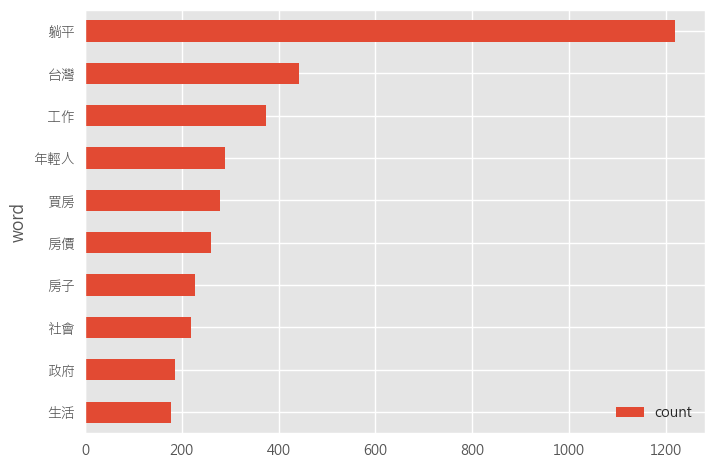

In [151]:
word_counts = pd.value_counts(noStop_df['word']).reset_index()
word_counts.columns = ['word', 'count'] 
freq_df_nostop = word_counts.sort_values(by='count', ascending=False)
freq_df_nostop.head(10).plot.barh(x='word', y='count').invert_yaxis()
plt.show()

# SnowNLP 情緒分析

In [152]:
from snownlp import SnowNLP

In [153]:
sent_df

,artUrl,artTitle,artDate,artContent,sentence
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,都第集了
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,竟然沒人開這一檔閒聊
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,這是一部顛覆的都市情感劇
6,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,沒有白富美的女一
8,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,也沒有高富帥的男一
...,...,...,...,...,...
28901,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,[陰天]連玩樂都不想,2023-02-13,總感覺有點悶又活得不耐煩，別人建議我去旅遊玩樂一下，說不定會感覺好一點。\r\n\r\n但是...,很花體力和精神力
28902,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,[陰天]連玩樂都不想,2023-02-13,總感覺有點悶又活得不耐煩，別人建議我去旅遊玩樂一下，說不定會感覺好一點。\r\n\r\n但是...,我應付得來嗎
28907,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,[陰天]連玩樂都不想,2023-02-13,總感覺有點悶又活得不耐煩，別人建議我去旅遊玩樂一下，說不定會感覺好一點。\r\n\r\n但是...,對什麼都感到無力厭煩
28908,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,[陰天]連玩樂都不想,2023-02-13,總感覺有點悶又活得不耐煩，別人建議我去旅遊玩樂一下，說不定會感覺好一點。\r\n\r\n但是...,真的是因為憂鬱症或憂鬱傾向嗎


In [154]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
senti_df = sent_df.copy()
senti_df['sentimentValue'] =senti_df.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
senti_df.head(3)

,artUrl,artTitle,artDate,artContent,sentence,sentimentValue
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,都第集了,0.525113
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,竟然沒人開這一檔閒聊,0.125853
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,這是一部顛覆的都市情感劇,0.996822


In [155]:
# 看一下情緒的分布
senti_df['sentimentValue'].describe()

count    1.889800e+04
mean     4.391546e-01
std      2.928166e-01
min      6.471969e-08
25%      1.831642e-01
50%      4.394020e-01
75%      6.609942e-01
max      9.999950e-01
Name: sentimentValue, dtype: float64

<Axes: >

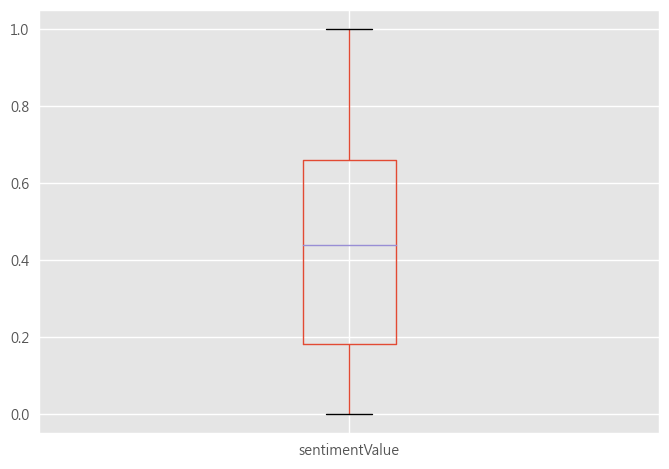

In [156]:
# 情緒分布的盒狀圖
boxplot = senti_df.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

In [157]:
sent_date = senti_df.copy()
sent_date['artDate'] =  pd.to_datetime(senti_df['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

,artDate,sentimentValue
0,2021-05,0.378437
1,2021-06,0.438422
2,2021-07,0.474715
3,2021-08,0.525324
4,2021-09,0.466143
5,2021-10,0.449500
6,2021-11,0.403823
7,2021-12,0.418804
8,2022-01,0.407318
9,2022-02,0.433947


C:\Users\a8184\AppData\Local\Temp\ipykernel_26672\857956447.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


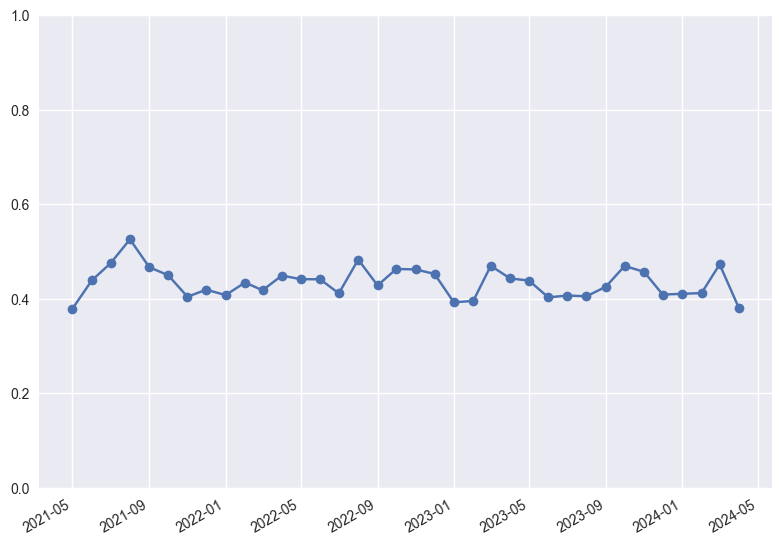

In [158]:
# 平均情緒分數時間趨勢
months = [period.to_timestamp() for period in sentiment_count['artDate']]   # 將 PeriodIndex 中的每個 Period 物件轉換為對應的 datetime 物件
y = sentiment_count['sentimentValue']

plt.style.use('seaborn')

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.ylim(0, 1)

plt.show()

從情緒分數可以看出大部分數值均小於0.5，表示大部分文章的情緒都是偏負向的

# TF-IDF
用來取出重要字詞

In [159]:
# 每篇文章的總詞彙數
total_words = noStop_df.groupby(['artUrl'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

,artUrl,total
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,42
1,https://www.ptt.cc/bbs/China-Drama/M.169899146...,96
2,https://www.ptt.cc/bbs/Gossiping/M.1622344364....,675
3,https://www.ptt.cc/bbs/Gossiping/M.1622810204....,6
4,https://www.ptt.cc/bbs/Gossiping/M.1622975406....,44
...,...,...
620,https://www.ptt.cc/bbs/job/M.1641443264.A.EF6....,250
621,https://www.ptt.cc/bbs/prozac/M.1632232347.A.6...,89
622,https://www.ptt.cc/bbs/prozac/M.1667170649.A.7...,105
623,https://www.ptt.cc/bbs/prozac/M.1667221824.A.6...,40


In [160]:
# 計算各詞彙在各文章中出現的次數
word_count = noStop_df.groupby(['artUrl','word'],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)
word_count

,artUrl,word,count
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一部,1
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,人生,1
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,今年,1
3,https://www.ptt.cc/bbs/China-Drama/M.165157889...,候選,1
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,劇王,1
...,...,...,...
37483,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,資料,1
37484,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,躺平,1
37485,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,預訂,1
37486,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,體力,1


In [161]:
lie_flat_words = word_count.merge(total_words,on = 'artUrl',how = 'left')
lie_flat_words

,artUrl,word,count,total
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一部,1,42
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,人生,1,42
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,今年,1,42
3,https://www.ptt.cc/bbs/China-Drama/M.165157889...,候選,1,42
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,劇王,1,42
...,...,...,...,...
37483,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,資料,1,29
37484,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,躺平,1,29
37485,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,預訂,1,29
37486,https://www.ptt.cc/bbs/prozac/M.1676291646.A.C...,體力,1,29


### 計算tf-idf

In [162]:
# 計算tf
lie_flat_words_tf_idf = lie_flat_words.assign(tf = lie_flat_words.iloc[:,2]/lie_flat_words.iloc[:,3])
lie_flat_words_tf_idf.head()

,artUrl,word,count,total,tf
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一部,1,42,0.02381
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,人生,1,42,0.02381
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,今年,1,42,0.02381
3,https://www.ptt.cc/bbs/China-Drama/M.165157889...,候選,1,42,0.02381
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,劇王,1,42,0.02381


In [163]:
# 計算每個詞彙出現在幾篇文章中
idf_df = lie_flat_words.groupby(['word'],as_index=False).size()
lie_flat_words_tf_idf = lie_flat_words_tf_idf.merge(idf_df,on = 'word',how = 'left')
lie_flat_words_tf_idf.head()

,artUrl,word,count,total,tf,size
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一部,1,42,0.02381,1
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,人生,1,42,0.02381,80
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,今年,1,42,0.02381,35
3,https://www.ptt.cc/bbs/China-Drama/M.165157889...,候選,1,42,0.02381,1
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,劇王,1,42,0.02381,1


In [164]:
# 計算idf
lie_flat_words_tf_idf = lie_flat_words_tf_idf.assign(idf = lie_flat_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))

lie_flat_words_tf_idf = lie_flat_words_tf_idf.drop(labels=['size'],axis=1)
lie_flat_words_tf_idf.head()

,artUrl,word,count,total,tf,idf
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一部,1,42,0.02381,2.795880
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,人生,1,42,0.02381,0.892790
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,今年,1,42,0.02381,1.251812
3,https://www.ptt.cc/bbs/China-Drama/M.165157889...,候選,1,42,0.02381,2.795880
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,劇王,1,42,0.02381,2.795880


In [165]:
# 計算tf*idf
lie_flat_words_tf_idf = lie_flat_words_tf_idf.assign(tf_idf = lie_flat_words_tf_idf.iloc[:,4] * lie_flat_words_tf_idf.iloc[:,5])
lie_flat_words_tf_idf.head()

,artUrl,word,count,total,tf,idf,tf_idf
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,一部,1,42,0.02381,2.795880,0.066569
1,https://www.ptt.cc/bbs/China-Drama/M.165157889...,人生,1,42,0.02381,0.892790,0.021257
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,今年,1,42,0.02381,1.251812,0.029805
3,https://www.ptt.cc/bbs/China-Drama/M.165157889...,候選,1,42,0.02381,2.795880,0.066569
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,劇王,1,42,0.02381,2.795880,0.066569


### 計算tf-idf最高的字

In [166]:
with open('dict\stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [167]:
# 從每篇文章挑選出tf-idf最大的前十個詞
(lie_flat_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(20) # 排序看前十名

,word,size
4313,躺平,17
1306,台灣,14
2105,年輕人,13
2097,年級,12
952,八年級,12
2026,工作,11
1963,小孩,11
278,七年級,11
2418,房價,9
790,保全,9


從結果我們可以看到：

躺平、年輕人、小孩、房價都屬於較為重要的字詞，因此我們進一步探索

# Pairwise Correlation

In [168]:
data_cor = sent_df.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor.head(3)

,artUrl,artTitle,artDate,artContent,sentence,word
0,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,都第集了,第集
2,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,竟然沒人開這一檔閒聊,沒人開 這一 閒聊
4,https://www.ptt.cc/bbs/China-Drama/M.165157889...,[閒聊]沒有工作的一年~~,2022-05-03,都第10集了，\r\n竟然沒人開這一檔閒聊，\r\n這是一部顛覆的都市情感劇，\r\n沒有白...,這是一部顛覆的都市情感劇,一部 顛覆 都市 情感


In [169]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,iphone,po,ptt,一輩子,一間,七年級,上班,下去,下班,不努力,...,需求,需要,青年,面對,韭菜,頭期款,願意,顯示,高房價,高雄
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18893,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18894,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18895,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18896,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [170]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

,word1,iphone,po,ptt,一輩子,一間,七年級,上班,下去,下班,...,需求,需要,青年,面對,韭菜,頭期款,願意,顯示,高房價,高雄
0,iphone,1.000000,-0.002194,-0.002309,-0.002305,-0.002076,0.015168,-0.003314,-0.002794,-0.002609,...,-0.002268,-0.003238,-0.003806,-0.002940,-0.002077,-0.002231,-0.002842,-0.002122,-0.002794,-0.002491
1,po,-0.002194,1.000000,0.122380,-0.001615,-0.001454,0.023747,-0.002322,-0.001958,-0.001828,...,-0.001589,-0.002268,-0.002666,-0.002059,-0.001455,-0.001563,-0.001991,-0.001486,-0.001958,-0.001745
2,ptt,-0.002309,0.122380,1.000000,-0.001699,-0.001531,-0.002167,-0.002443,-0.002060,-0.001924,...,-0.001672,-0.002387,-0.002806,-0.002167,-0.001531,-0.001645,-0.002095,-0.001564,-0.002060,-0.001836
3,一輩子,-0.002305,-0.001615,-0.001699,1.000000,-0.001528,-0.002163,-0.002439,-0.002056,-0.001920,...,-0.001669,-0.002383,-0.002801,-0.002163,-0.001529,-0.001642,0.020779,-0.001562,-0.002056,-0.001833
4,一間,-0.002076,-0.001454,-0.001531,-0.001528,1.000000,-0.001949,-0.002197,-0.001852,-0.001730,...,-0.001504,-0.002147,-0.002523,-0.001949,-0.001377,-0.001479,-0.001884,-0.001407,-0.001852,0.022897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,頭期款,-0.002231,-0.001563,-0.001645,-0.001642,-0.001479,-0.002095,-0.002362,-0.001991,-0.001859,...,-0.001616,-0.002307,-0.002712,-0.002095,-0.001480,1.000000,-0.002025,-0.001512,-0.001991,-0.001775
296,願意,-0.002842,-0.001991,-0.002095,0.020779,-0.001884,-0.002667,-0.003007,-0.002535,-0.002368,...,-0.002058,-0.002938,-0.003453,-0.002667,0.023484,-0.002025,1.000000,-0.001925,-0.002535,-0.002260
297,顯示,-0.002122,-0.001486,-0.001564,-0.001562,-0.001407,-0.001992,-0.002246,-0.001893,-0.001768,...,-0.001537,-0.002194,0.036050,-0.001992,-0.001407,-0.001512,-0.001925,1.000000,-0.001893,-0.001687
298,高房價,-0.002794,-0.001958,-0.002060,-0.002056,-0.001852,-0.002623,-0.002957,-0.002493,-0.002328,...,-0.002024,-0.002889,0.043686,0.058220,-0.001853,-0.001991,-0.002535,-0.001893,1.000000,-0.002222


In [171]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=0).head(20)

,word1,word2,cor
3270,轉載,不可,0.925722
81010,不可,轉載,0.925722
3911,不婚,不生,0.774034
3313,不生,不婚,0.774034
53504,居住,正義,0.659560
31378,正義,居住,0.659560
15592,青年,勞工,0.477157
87651,勞工,青年,0.477157
59321,結婚,生子,0.380374
66497,生子,結婚,0.380374


從TF-IDF值我們可以看較為重要的字詞有
1. 躺平
2. 年輕人
3. 小孩
4. 房價


找出他們的相關詞彙，看看他們分別指什麼意思

In [172]:
lay_sum = word_cor_df[(word_cor_df["word1"] == "躺平")].sort_values(by = ['cor'], ascending = False).head(20)

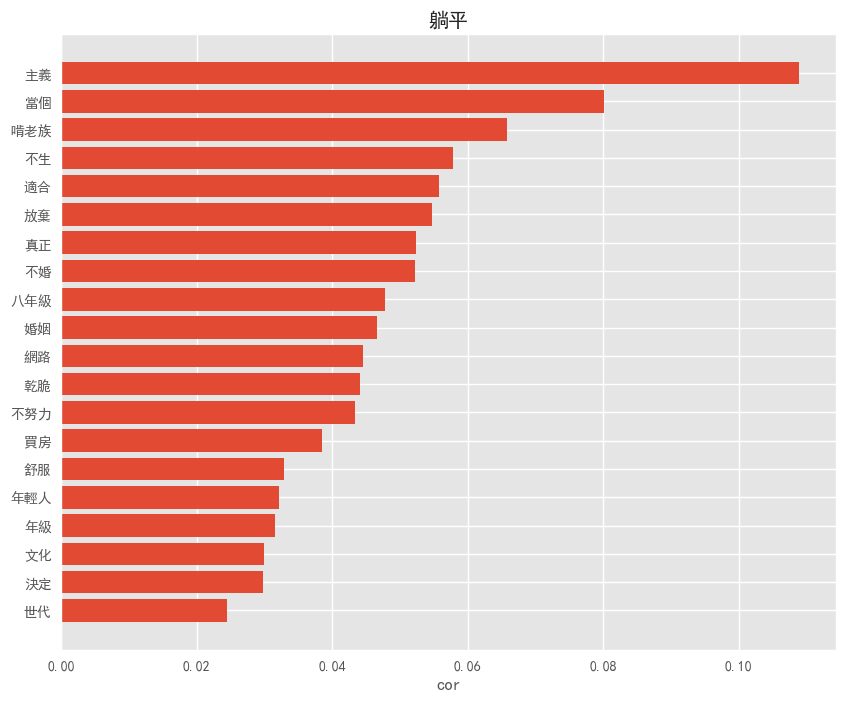

In [173]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.figure(figsize=(22,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('躺平')
plt.xlabel('cor')
plt.barh(lay_sum['word2'],lay_sum['cor'])
plt.gca().invert_yaxis()



plt.show()

可以看到與躺平相關程度較高的字詞有
* 啃老族
* 不生
* 不婚
* 放棄
* 不努力

因此我們可以知道躺平族的理念可能就是不婚不生並且放棄努力甚至成為啃老族

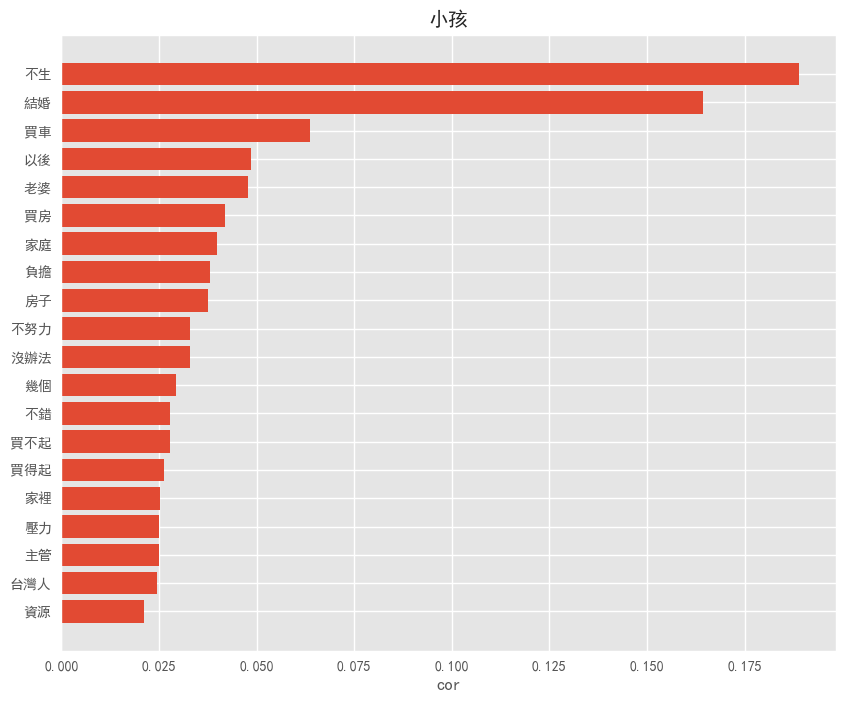

In [174]:
lay_sum = word_cor_df[(word_cor_df["word1"] == "小孩")].sort_values(by = ['cor'], ascending = False).head(20)
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.figure(figsize=(22,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('小孩')
plt.xlabel('cor')
plt.barh(lay_sum['word2'],lay_sum['cor'])
plt.gca().invert_yaxis()



plt.show()

與小孩關聯性最高的詞彙是不生

代表躺平族不願意生小孩，這樣的況可能會加劇台灣少子化

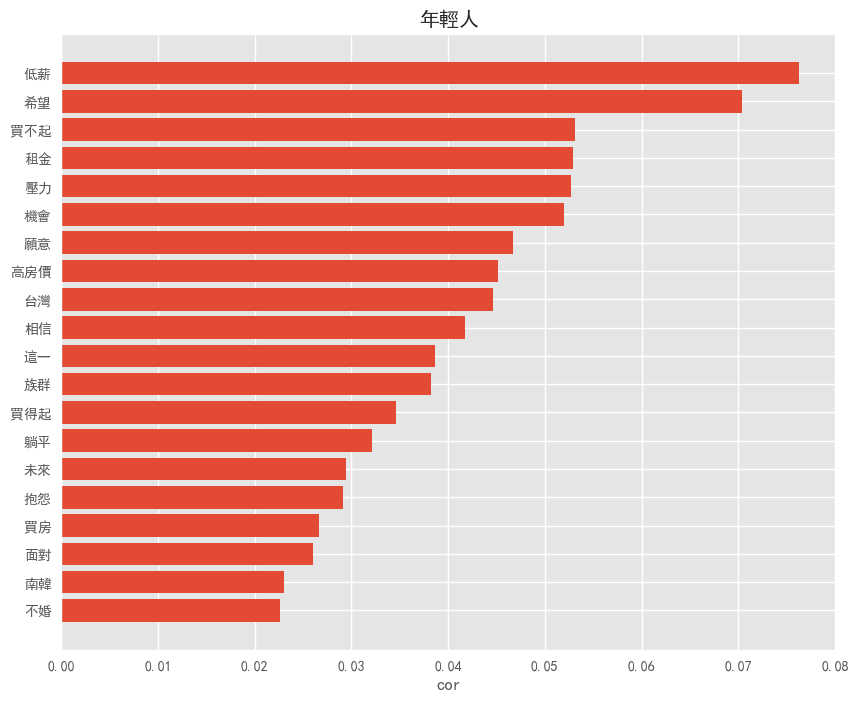

In [175]:
lay_sum = word_cor_df[(word_cor_df["word1"] == "年輕人")].sort_values(by = ['cor'], ascending = False).head(20)
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.figure(figsize=(22,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('年輕人')
plt.xlabel('cor')
plt.barh(lay_sum['word2'],lay_sum['cor'])
plt.gca().invert_yaxis()



plt.show()

年輕人相關的詞彙當中可以發現一些年輕人所面臨的困境：
* 低薪
* 高房價

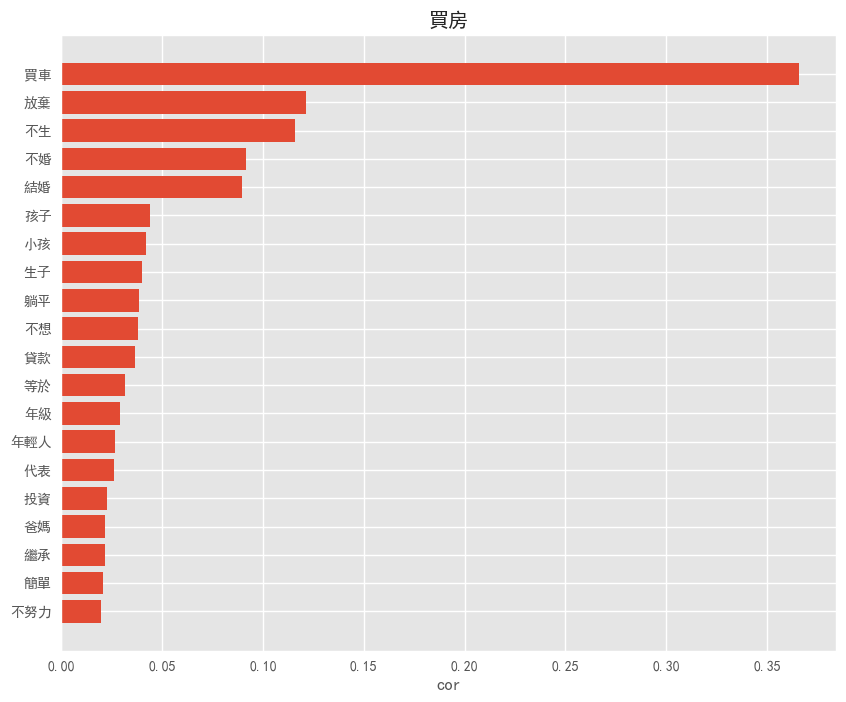

In [176]:
lay_sum = word_cor_df[(word_cor_df["word1"] == "買房")].sort_values(by = ['cor'], ascending = False).head(20)
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.figure(figsize=(22,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('買房')
plt.xlabel('cor')
plt.barh(lay_sum['word2'],lay_sum['cor'])
plt.gca().invert_yaxis()



plt.show()

與買房最相關的詞彙是買車、買不起、不生、不婚

## 詞彙關係圖（詞頻前60且相關性高於0.3）

In [178]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(100).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [179]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.1]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

,word1,word2,cor
0,不生,不婚,0.774034
1,買車,不婚,0.119766
2,不婚,不生,0.774034
3,小孩,不生,0.189029
4,買房,不生,0.115857
5,買車,不生,0.170414
6,年輕,世代,0.123745
7,躺平,主義,0.108944
8,物價,低薪,0.105031
9,高房價,低薪,0.242681


In [180]:
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

In [181]:
dict = __builtins__.dict

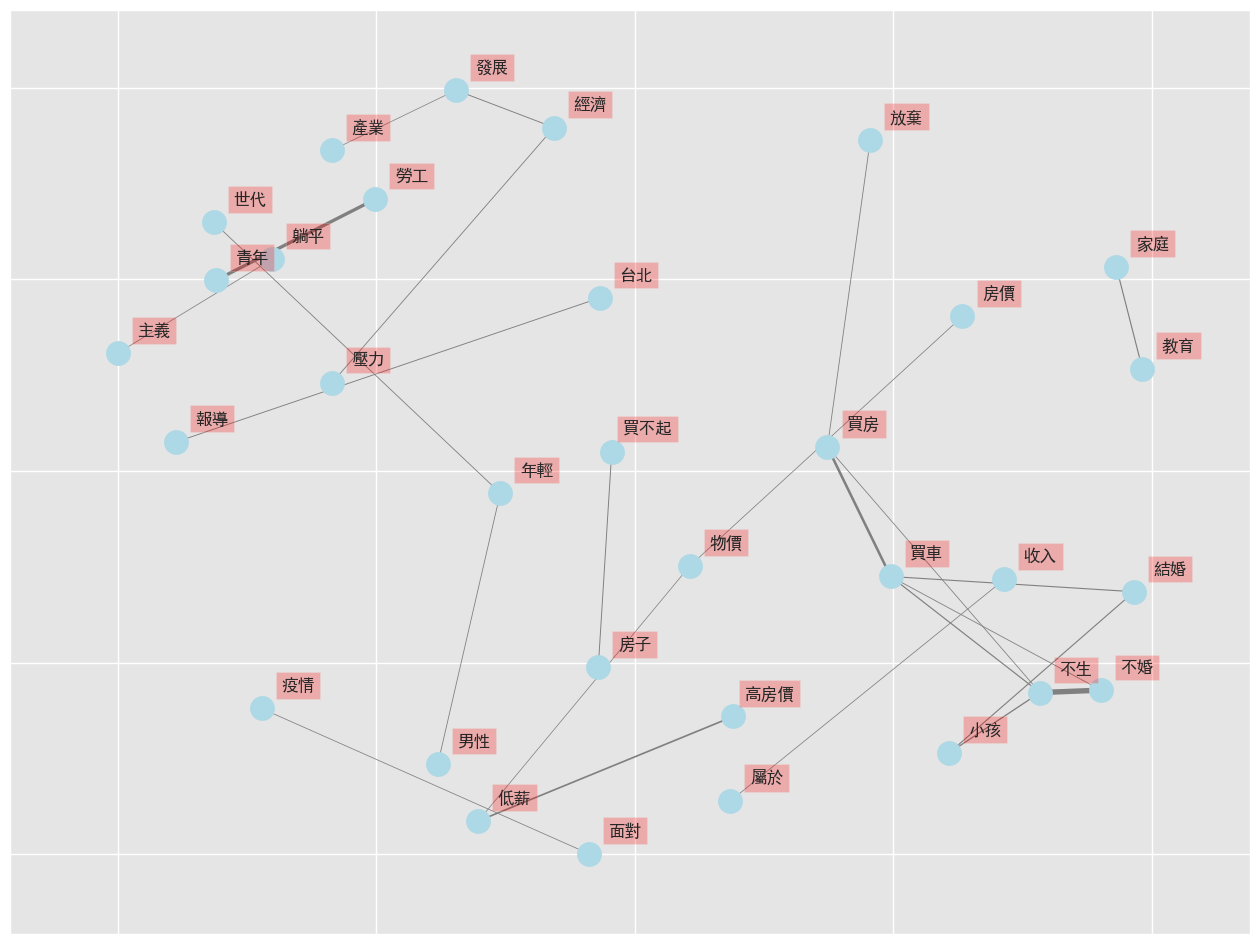

In [182]:
fig, ax = plt.subplots(figsize=(16, 12))

pos = nx.spring_layout(g, k=0.5)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)
    
plt.show()

從詞彙關係圖我們可以更進一步確認詞彙彼此的關係，綜合以上分析方法總結以下

* 躺平族年齡：
  * 以七八年級的年輕人居多
* 躺平族主要成因：
  * 低薪
  * 高房價
  * 看不到買房買車的希望
* 躺平族理念與行為：
  * 不再努力
  * 啃老
  * 放棄買房買車的人生目標
  * 不婚不生

### 總結：
台灣躺平族選擇躺平的原因是因為他們認為自己面臨一個低薪高房價的環境，不管再怎麼努力也無法達成人生目標，因此他們放棄了傳統大眾的人生目標，追求當下的安逸。